In [6]:
!pip install geopandas rasterio scikit-learn numpy matplotlib


In [7]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [8]:
# Abrir a imagem raster
raster_path = "caminho/IMG.tif"
with rasterio.open(raster_path) as src:
    bands = src.read()  # Ler todas as bandas
    transform = src.transform
    profile = src.profile  # Metadados para salvar depois

# Converter para formato (n_pixels, n_bandas)
n_bands, height, width = bands.shape
pixels = bands.reshape(n_bands, -1).T  # Transforma para (n_pixels, n_bandas)


In [11]:
# Abrir o shapefile com as amostras
shapefile_path = r"caminho\.shp"
gdf = gpd.read_file(shapefile_path)

# Garantir que as amostras têm uma coluna 'classe' com as categorias
print(gdf.head())  # Verifique se a coluna 'classe' existe


              CLASSE DT_MAPEAME ANALISTA  area_gis  \
0        PASTO LIMPO        NaT     JOAO    3.9754   
1          EUCALIPTO        NaT     JOAO    3.3260   
2       BENFEITORIAS        NaT     JOAO    2.2768   
3  CANA DE TERCEIROS        NaT     JOAO    1.9466   
4              GRÃOS        NaT     JOAO   16.3494   

                                            geometry  
0  POLYGON ((830093.567 7506533.619, 830040.34 75...  
1  POLYGON ((829233.935 7505454.892, 828964.421 7...  
2  POLYGON ((829498.866 7504896.628, 829448.856 7...  
3  POLYGON ((829172.996 7504424.89, 829167.809 75...  
4  POLYGON ((827083.19 7503911.556, 826911.713 75...  


In [14]:
# Criar listas para armazenar os dados de treinamento
X_train = []  # Valores dos pixels
y_train = []  # Classes

with rasterio.open(raster_path) as src:
    for _, row in gdf.iterrows():
        geom = [row.geometry]  # Pegar a geometria do ponto/polígono
        classe = row['CLASSE']  # Pegar a classe associada
        
        # Recortar o raster no local da amostra
        out_image, _ = mask(src, geom, crop=True, all_touched=True)
        
        # Adicionar os valores das bandas ao conjunto de treino
        valores_pixel = out_image[:, 0, 0]  # Pegamos o pixel central da amostra
        X_train.append(valores_pixel)
        y_train.append(classe)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [24]:
    # Criar um dicionário para converter classes textuais em números
classes_unicas = gdf['CLASSE'].unique()
classe_dict = {classe: idx for idx, classe in enumerate(classes_unicas)}

print("Dicionário de classes:", classe_dict)


Dicionário de classes: {'PASTO LIMPO': 0, 'EUCALIPTO': 1, 'BENFEITORIAS': 2, 'CANA DE TERCEIROS': 3, 'GRÃOS': 4, 'VEGETAÇÃO': 5, "CORPOS D'ÁGUA": 6, 'CULTURAS PERENES': 7}


In [25]:
# Aplicar a conversão no conjunto de treinamento
y_train = np.array([classe_dict[classe] for classe in gdf['CLASSE']])


In [26]:
# Criar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [27]:
# Prever a classe de cada pixel
predicted = rf.predict(pixels)

# Converter de volta para formato imagem
classified = predicted.reshape(height, width).astype(np.uint8)

# Atualizar metadados para salvar a imagem classificada
profile.update(dtype=rasterio.uint8, count=1)

# Salvar raster classificado
output_raster = "C:/Users/joao.lucas/Desktop/Kmeans/classificado_RF.tif"
with rasterio.open(output_raster, "w", **profile) as dst:
    dst.write(classified, 1)

print("Classificação salva em:", output_raster)


Classificação salva em: C:/Users/joao.lucas/Desktop/Kmeans/classificado_RF.tif


In [28]:
# Atualizar metadados para salvar a imagem classificada
profile.update(dtype=rasterio.uint8, count=1)  # Apenas 1 banda para a classe

# Salvar raster classificado
output_raster = "caminho/classificado_RF.tif"
with rasterio.open(output_raster, "w", **profile) as dst:
    dst.write(classified.astype(rasterio.uint8), 1)

print("Classificação salva em:", output_raster)


Classificação salva em: caminho/classificado_RF.tif


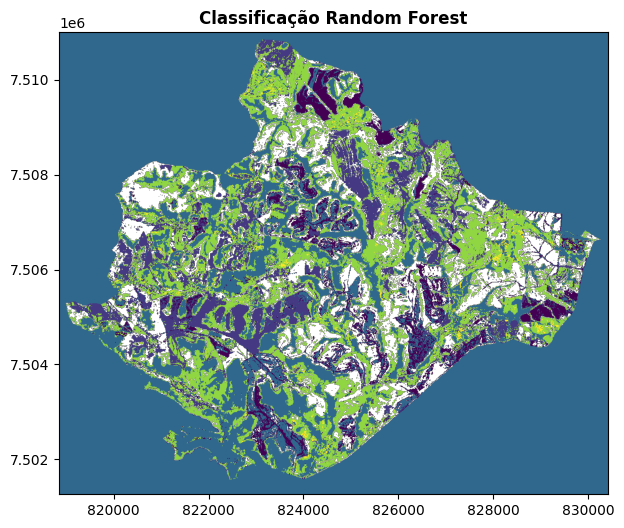

In [29]:
# Abrir e exibir a imagem classificada
with rasterio.open(output_raster) as classified_raster:
    fig, ax = plt.subplots(figsize=(10, 6))
    show(classified_raster, cmap="viridis", ax=ax, title="Classificação Random Forest")
    plt.show()


Precisão do Modelo

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividir os dados (70% treino, 30% teste)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# Treinar o modelo novamente com os dados de treino
rf.fit(X_train_split, y_train_split)

# Fazer previsões no conjunto de teste
y_pred = rf.predict(X_test_split)


In [31]:
# Calcular a acurácia geral
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Acurácia do modelo: {accuracy:.2%}")

# Exibir o relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test_split, y_pred))

# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test_split, y_pred))


Acurácia do modelo: 33.33%
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         5
           2       1.00      0.14      0.25         7
           3       0.33      1.00      0.49        14
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1

    accuracy                           0.33        45
   macro avg       0.17      0.14      0.09        45
weighted avg       0.26      0.33      0.19        45

Matriz de Confusão:
[[ 0  0  0 11  0  0  0  0]
 [ 0  0  0  5  0  0  0  0]
 [ 0  0  1  6  0  0  0  0]
 [ 0  0  0 14  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  2  0  0  0  0]
 [ 0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]]


c:\Users\joao.lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joao.lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joao.lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_